In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import time
from scipy.stats import laplace, norm
from scipy.optimize import curve_fit
#from scipy.stats import norm

%matplotlib inline

In [12]:
deltatimes = pd.read_csv("../csvs/resonant/deltatimes.csv")
deltatimes.head()


,ID,t,t_shadow
0,0.0,5.330628e+03,9.377841e+03
1,1.0,9.999999e+07,9.999999e+07
2,2.0,9.999999e+07,9.999999e+07
3,3.0,5.946887e+06,3.941298e+06
4,4.0,3.711381e+05,6.345772e+05


In [4]:
scores = pd.read_csv("../csvs/resonant/significance_scores.csv")

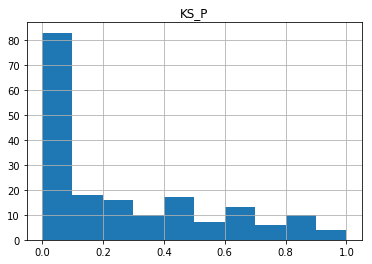

173


In [5]:
scores.hist("KS_P")
plt.show()
print (len(np.where(scores["KS_P"]>1e-6)[0]))
res_keep = scores[scores["KS_P"]>1e-6]
# interesting how we retain 173 out of 184 with the same cut
# we retain a significantly higher proportion, about 94% compared to with the randomly generated systems

In [16]:
#pull up gaussian fits, and the P value significance, to take all systems with above 1-e6.
#this is a reasonable threshold because higher than that removes many systems, and lower than that includes many odd systems
info = pd.read_csv("../csvs/resonant/Gaussian_Fits_317.csv")

In [17]:
trimmed = deltatimes[(deltatimes["t"]<1e7) & (deltatimes["t"]>1e4)
                    & (deltatimes["t_shadow"]<1e7)& (deltatimes["t_shadow"]>1e4)]
trimmed.shape

(184, 3)

In [18]:
trimmed_ids = trimmed["ID"].values
print (trimmed_ids[:4], type(trimmed_ids[0]), type(info.loc[0]["ID"]))
trimmed_info = info.loc[ info["ID"].isin(trimmed_ids) ]
print (trimmed_info.shape)

[3. 4. 5. 8.] <class 'numpy.float64'> <class 'numpy.float64'>
(184, 7)


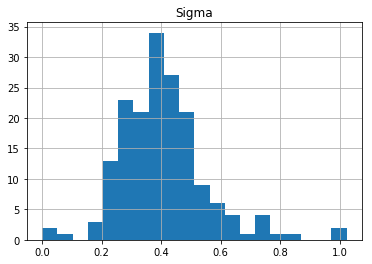

In [19]:
valid_gaus_params= trimmed_info[trimmed_info["ID"].isin((res_keep["ID"]).values)]
valid_gaus_params.hist("Sigma", bins = 20)
plt.show()

Average Sigma 0.4073301456573943 Std in Sigma 0.14840236070328702
Max valid sigma 1.023404614882976


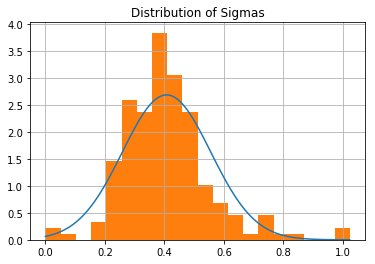

In [20]:
mu_fit, sig_fit =  norm.fit(valid_gaus_params["Sigma"].values)
print ("Average Sigma", mu_fit, "Std in Sigma", sig_fit)

fig = plt.figure()
ax = fig.add_subplot("111")
x = np.linspace(0, valid_gaus_params["Sigma"].max(), 100)
prob_sig = norm.pdf(x, mu_fit, sig_fit)
plt.plot(x, prob_sig)
valid_gaus_params.hist("Sigma", normed = 1, ax = ax, bins = 20)

print("Max valid sigma", valid_gaus_params["Sigma"].max())
plt.title("Distribution of Sigmas")
plt.show()

In [21]:
norm_prob_sig = prob_sig/(prob_sig.sum())

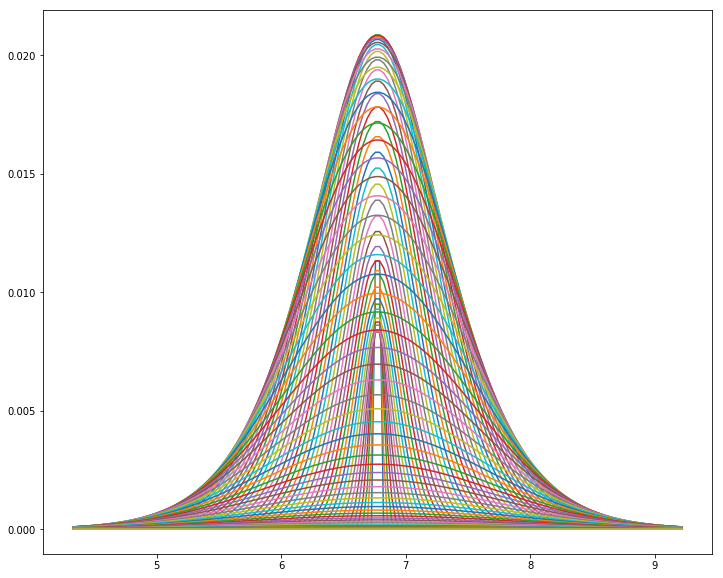

In [22]:
# Analytically over each of the mu;s, how to combine the sigmas?
max_sigma = mu_fit # the center of the distribution
increments = 150 

plt.figure(figsize=(12, 10))


total_y= np.zeros(increments)
for j in range(1,int(prob_sig.shape[0]), 1):
    fixed_sigma=x[j]
    t_sim = np.log10(trimmed["t"].values[0])
    bins = np.linspace(t_sim -6*max_sigma, t_sim +6*max_sigma, increments)
    final_y = norm.pdf(bins, t_sim, fixed_sigma*2**0.5)* norm_prob_sig[j]       
    total_y +=final_y
    plt.plot(bins, final_y )

end = time.time()
plt.show()

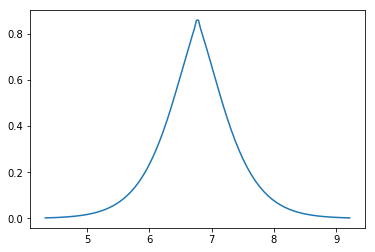

In [23]:
bins = np.linspace(t_sim -6*max_sigma, t_sim +6*max_sigma, increments)
plt.plot(bins, total_y)
width = (12*max_sigma)/(increments-1)
plt.show()

The laplace distribution has a mean of $\mu$, and a varience of $2b^2$.  P(x) = $\frac{1}{2b}exp(\frac{-|x-\mu|}{b})$

In [24]:
def laplace_fit(data, mean, spread):
    return np.exp(-np.abs(data-mean)/spread)/2./spread

[6.77428966 0.52077961]
[0.00356512 0.00505388]
params [0.         0.52077961]


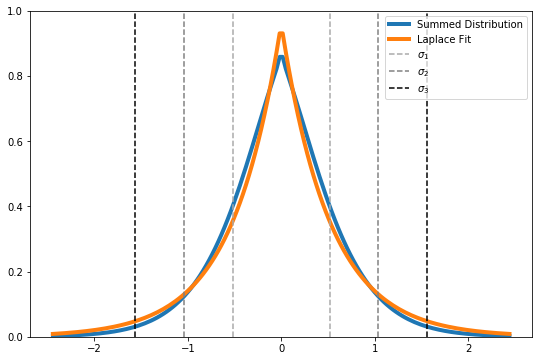

In [25]:
# Function for optimizing the difference between total_Y(graph from)

plt.figure (figsize=(9, 6))
popt, pcov = curve_fit(laplace_fit, bins, total_y)
print (popt)
perr = np.sqrt(np.diag(pcov))
print (perr)

# center distribution, as we're currently only interested in the spread
bins -= popt[0]
popt[0] = 0

plt.plot(bins, total_y, label = "Summed Distribution", linewidth = 4)
print("params", popt)


plt.plot(bins, laplace_fit(bins, *popt), label = "Laplace Fit", linewidth = 4)


colors = ["darkgrey","grey", "black"]
for i in range(1,4):
    plt.axvline(popt[0]+i*popt[1], ls= "dashed", label = "$\sigma_{0}$".format(i), color = colors[i-1])
    plt.axvline(popt[0]-i*popt[1], ls= "dashed", color = colors[i-1])
plt.legend()
plt.ylim([0,1])
plt.show()

In [26]:
#try testing with the resonant dataset
res_test = pd.read_csv("../csvs/resonant/resonant_instability_times.csv", index_col=0)
res_test.head()

,runstring,seed,pairindex,j,k,Zstar,libfac,Zcom,instability_time,shadow_instability_time
0,0000000.bin,3500000,1,12,1,0.021650,0.007181,0.041669,1.545872e+06,3.063700e+06
1,0000001.bin,700001,1,19,2,0.060291,0.523204,0.010656,9.990000e+08,9.990000e+08
2,0000002.bin,2,0,6,1,0.026353,0.012995,0.050319,9.990000e+08,9.990000e+08
3,0000003.bin,2100003,0,5,2,0.023511,0.713415,0.102200,2.287671e+06,8.392234e+06
4,0000004.bin,700004,0,12,1,0.017473,0.003612,0.039803,9.668931e+05,3.380350e+05


In [27]:
test_samples = res_test[ (np.log10(res_test["instability_time"])<7 ) &
                       (np.log10(res_test["shadow_instability_time"])<7 ) &
                       (np.log10(res_test["instability_time"])>4 ) &
                       (np.log10(res_test["shadow_instability_time"])>4 ) ]
test_samples.shape

(5039, 10)

Laplacian params [0.         0.52077961]
Mean sig 0.4073301456573943


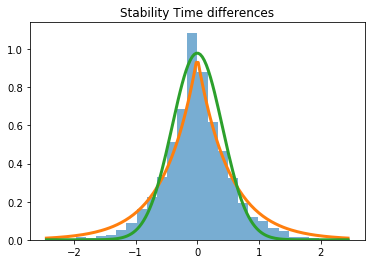

In [28]:
diff_data = np.log10(test_samples["instability_time"]) - np.log10(test_samples["shadow_instability_time"])
plt.hist(diff_data, bins= 30, normed=1, alpha = 0.6)

#plot with laplace fit
plt.plot(bins, laplace_fit(bins, *popt), label = "Laplace Fit", linewidth = 3)
print("Laplacian params", popt[:])

#plot with gaussian with mean width
sig_plot = norm.pdf(bins, 0, mu_fit)
print("Mean sig", mu_fit)
plt.plot(bins, sig_plot, linewidth = 3)
plt.title("Stability Time differences")
plt.show()
